In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               retain_graph=True, # ?
                               create_graph=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5]):
        super().__init__()

        self.blocks = nn.Sequential(
            nn.Linear(in_chan, chans[0]),
            nn.Tanh(),
            nn.Linear(chans[0], chans[1]),
            nn.Tanh(),
            nn.Linear(chans[1], chans[0]),
            nn.Tanh(),
            nn.Linear(chans[0], out_chan)
        )

    def forward(self, x):
        return self.blocks(x)
    

class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()

        # Predicts Chi
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        #self.e = torch.nn.Parameter(torch.tensor(0.8))
        #self.mu = torch.nn.Parameter(torch.tensor(0.00018))
        #self.M = torch.nn.Parameter(torch.tensor(.04))

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)))
        #self.mu_ = torch.nn.Parameter(torch.randn(1))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)))
        self.p_ = torch.nn.Parameter(torch.abs(torch.randn(1)))

        # Use initial guess
        #self.e_ = torch.nn.Parameter(torch.arctanh(torch.log(torch.tensor(0.5)))) # 0.8
        #self.M_ = torch.nn.Parameter(torch.log(torch.tensor(0.01))) # 0.04
        #self.p_ = torch.nn.Parameter(torch.log(torch.tensor(200.))) # 220.

        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        #self.mu_.requires_grad = True
        self.M_.requires_grad = True
        self.p_.requires_grad = True

    def forward(self, x):
        # Output u
        # TODO: no gradient for model params

        #mu = self.get_mu()
        p = self.get_p()
        M  = self.get_M()
        e  = self.get_e()

        r = p / (1 + e*torch.cos(self.nn(x)))
        return r
    
    def get_e(self):
        #return self.e_
        return torch.tanh(torch.exp(self.e_))
    
    def get_M(self):
        return self.M_
        #return torch.exp(self.M_)
    
    def get_mu(self):
        return
        #return torch.exp(self.mu_)
    
    def get_p(self):
        return self.p_
        #return torch.exp(self.p_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        # TODO: Implement physical loss based on differential equations
        chi = self.nn(phi)

        #mu = self.get_mu()
        p  = self.get_p()
        M  = self.get_M()
        e  = self.get_e()

        dchi = grad(chi, phi)[0]
        ddchi = grad(dchi, phi)[0]

        ode1 = dchi**2 - 1 + 2*M/p*(3 + e*torch.cos(chi))
        ode2 = ddchi - M/p*e*torch.sin(chi)

        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)

        return loss1 * lambda1 + loss2 * lambda2

In [3]:

class rPINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()

        # Predicts r
        self.nn = NNBlock(in_chan, out_chan, chans=chans)


        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)))
        self.p_ = torch.nn.Parameter(torch.abs(torch.randn(1)))

        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        self.M_.requires_grad = True
        self.p_.requires_grad = True

    def forward(self, x):
        return self.nn(x)
    
    def get_e(self):
        return torch.tanh(torch.exp(self.e_))
    
    def get_M(self):
        return self.M_
    
    def get_p(self):
        return self.p_

    def physical_loss(self, phi):
        r = self.nn(phi)

        #mu = self.get_mu()
        p  = self.get_p()
        M  = self.get_M()
        e  = self.get_e()

        dr = grad(r, phi)[0]
        ode = dr**2 - 2*M*r**4*(1/r - (1 + e)/p)*(1/r - (1-e)/p)*(1/r - 1/(2*M) + 2/(p*(1-e**2)))
        
        loss1 = torch.mean(ode**2)
        return loss1

In [4]:
data1 = pd.read_csv("data/astrometry_NACO.csv")
data2 = pd.read_csv("data/astrometry_SHARP.csv")


In [5]:
micro_arcsec_to_au = torch.pi / (3600*180) * 8 * 1000 * 206265 * 1e-2 # to units 1e-2 AU

x1 = data1.iloc[:,1].values * micro_arcsec_to_au 
y1 = data1.iloc[:,3].values * micro_arcsec_to_au

x2 = data2.iloc[:,1].values * micro_arcsec_to_au
y2 = data2.iloc[:,3].values * micro_arcsec_to_au

# X values
#phi1 = np.arctan(y1/x1)
#phi2 = np.arctan(y2/x2)
#phi = torch.cat((torch.tensor(phi1, dtype=torch.float32), torch.tensor(phi2, dtype=torch.float32))).unsqueeze(1)

#phi_aug = phi + (torch.randint(low=0,high=3,size=phi.shape) - 1) * torch.pi


# Y values
r1 = np.sqrt(x1**2 + y1**2)
r2 = np.sqrt(x2**2 + y2**2)
r = torch.cat((torch.tensor(r1, dtype=torch.float32), torch.tensor(r2, dtype=torch.float32))).unsqueeze(1)

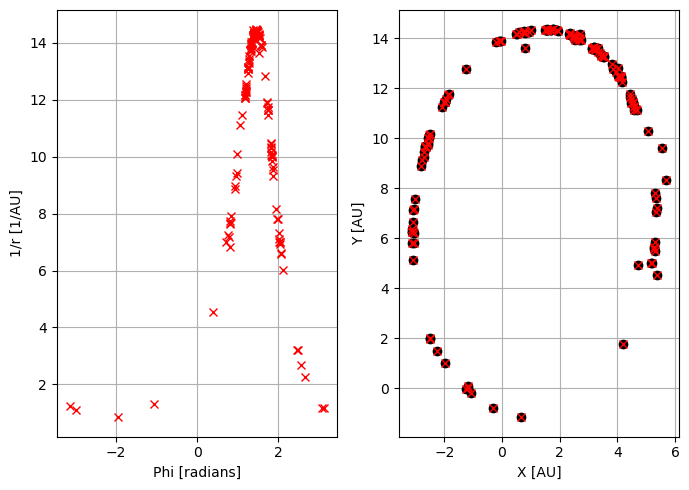

In [6]:
x_ = torch.cat((torch.tensor(x1), torch.tensor(x2))).unsqueeze(1)
y_ = torch.cat((torch.tensor(y1), torch.tensor(y2))).unsqueeze(1)

phi = np.arccos(x_/r)
phi = torch.where(y_<0., -phi, phi).float()



fig, ax = plt.subplots(figsize=(7,5), ncols=2)
#ax.set_xscale("log")

ax[0].plot(phi, r, 'rx')
ax[0].set_ylabel("1/r [1/AU]")
ax[0].set_xlabel("Phi [radians]")



ax[1].plot(np.cos(phi[:,0])*r[:,0], np.sin(phi[:,0])*r[:,0], 'ko')
ax[1].plot(x1, y1, 'rx')
ax[1].plot(x2, y2, 'rx')
ax[1].set_ylabel("Y [AU]")
ax[1].set_xlabel("X [AU]")

[axi.grid() for axi in ax]

plt.tight_layout()


#ax[1].set_ylim(-50,50); ax[1].set_xlim(-140, -60)

In [27]:
# Initialize model
lr = 1e-4

model = rPINN(1, 1, chans=[16,32,16])
#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters())
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses = [[], [], []]
params = [[], [], []]

Npi = 6
phi_lin = torch.linspace(-Npi*torch.pi, Npi*torch.pi, steps=1000).view(-1,1).requires_grad_(True)

#phys_loss_weight = .5


In [36]:
epochs = 20_000
phys_loss_weight = 1.

max_phys_loss_weight = 10.

# TODO: Implement inreasing weight of physical loss


for epoch in tqdm(range(epochs)):
    # Augment data
    phi_aug = phi + (torch.randint(low=0,high=3,size=phi.shape) - 1) * 2 * torch.pi

    out = model(phi_aug)

    MSEloss = criterion(out, r)

    PHYSloss = phys_loss_weight * model.physical_loss(phi_lin)
    #PHYSloss = phys_loss_weight * model.physical_loss(phi_aug)
    #phys_loss_weight *= 1.005
    #phys_loss_weight = min(phys_loss_weight, max_phys_loss_weight)

    loss = MSEloss + PHYSloss

    optimizer.zero_grad()
    loss.backward()
    #MSEloss.backward()
    #PHYSloss.backward()
    optimizer.step()

    losses[0].append(loss.detach().numpy())
    losses[1].append(MSEloss.detach().numpy())
    losses[2].append(PHYSloss.detach().numpy())

    params[0].append(model.get_e().item())
    #params[1].append(model.get_mu().item())
    params[1].append(model.get_p().item())
    params[2].append(model.get_M().item())


100%|██████████| 20000/20000 [02:07<00:00, 156.97it/s]


e = 0.7829647660255432
p = 3.0550172328948975
M = -0.06853190809488297


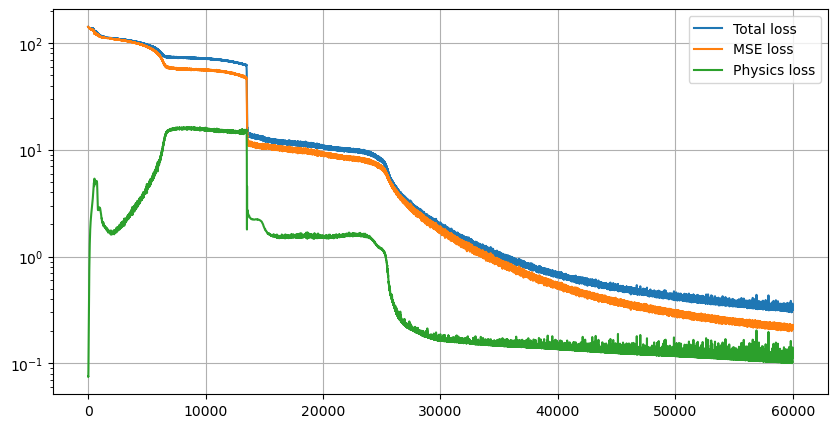

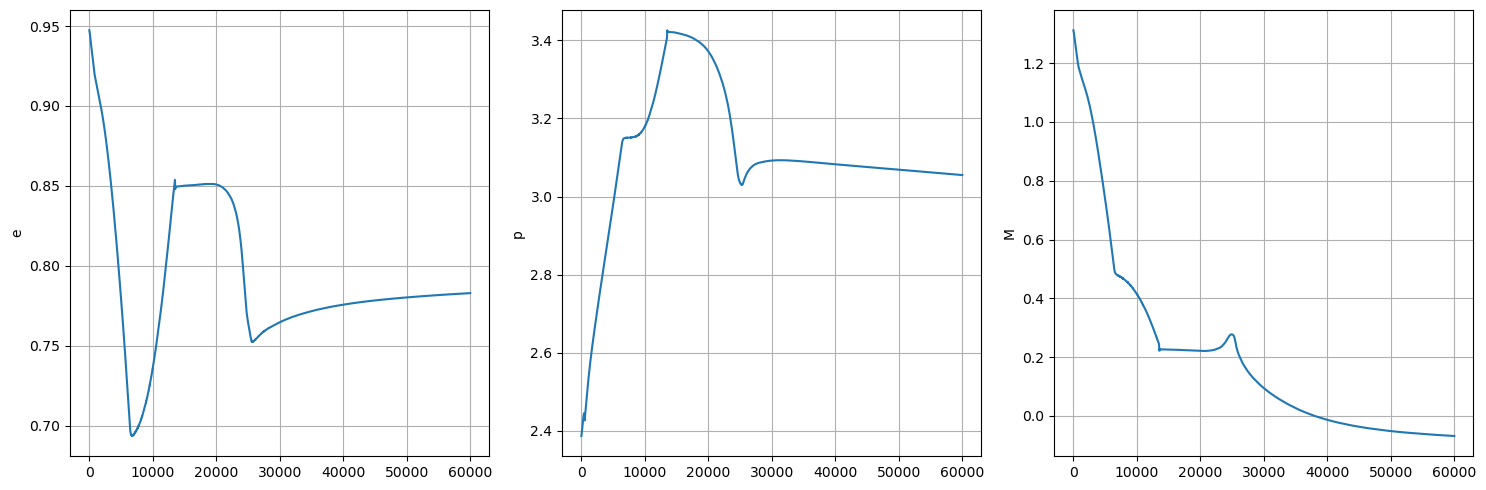

In [37]:
print("e =", model.get_e().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(losses[0], label="Total loss")
ax.plot(losses[1], label="MSE loss")
ax.plot(losses[2], label="Physics loss")

ax.grid()
ax.legend()
ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
#ax[1].set_ylabel(r"$\mu$")
ax[1].set_ylabel("p")
ax[1].grid()

ax[2].plot(params[2])
ax[2].set_ylabel("M")
ax[2].grid()

plt.tight_layout()
plt.show()

# e, p, M


#        self.e = torch.nn.Parameter(torch.tensor(0.8))
#        self.p = torch.nn.Parameter(torch.tensor(220.))
#        self.M = torch.nn.Parameter(torch.tensor(.04))
# mu ~ 1.8e-4


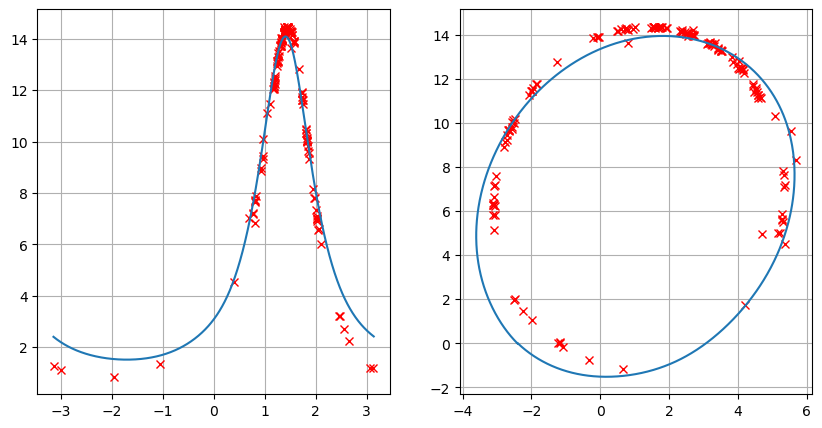

In [38]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
[axi.grid() for axi in ax]

#ax.set_xscale("log")

ax[0].plot(phi, r, 'rx')

theta = torch.linspace(-1*3.1415, 1*3.1415, steps=1000, dtype=torch.float32)
r_ = model(theta.unsqueeze(1)).detach().numpy()[:,0]
ax[0].plot(theta, r_)

#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(phi[:,0])*r[:,0], torch.sin(phi[:,0])*r[:,0], "rx")

theta = theta.numpy()
ax[1].plot(r_*np.cos(theta), r_*np.sin(theta));

#ax[0].set_xlim(0,3)
#ax[0].set_ylim(0,2)

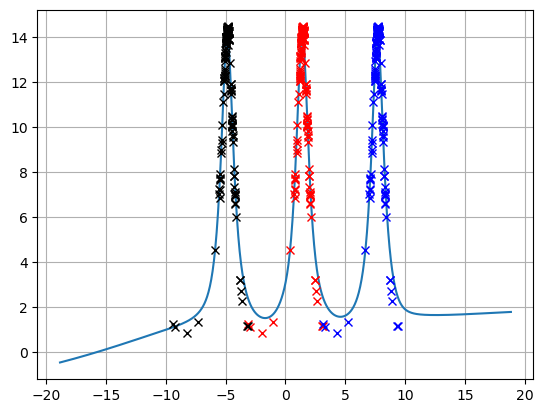

In [39]:
fig, ax = plt.subplots()
ax.grid()

r_ = model(phi_lin).detach().numpy()[:,0]
theta = phi_lin.detach().numpy()

ax.plot(theta[:,0], r_)


#    phi_aug = phi + (torch.randint(low=0,high=3,size=phi.shape) - 1) * 2 * torch.pi
ax.plot(phi, r, "rx")
phi_aug = phi + 2 * torch.pi
ax.plot(phi_aug, r, 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug, r, 'kx')

#plt.xlim(-2, -1)
#r = 1/u_

#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


In [ ]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#torch.save(state, f'S-STAR-rPINN.pth')